## Initialization

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import pandas_gbq

In [2]:
# FBProphet Modelling
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot

In [3]:
from collections import defaultdict

In [4]:
# data visualization
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
sns.set()

### Default constants

In [5]:
BUCKET_NAME = "homework_rl3154_data"
PROJECT_BUCKET = "project"
FOLDER_NAME = "electricity_load_data"
BIG_QUERY_TABLE_NAME = "project_dataset.agg_electricity_load_data_daily"


# Get Data

In [6]:
sql_query = f"""
    SELECT
        zone_name
        , daily_timestamp AS timestamp
        , SUM(sum_rtd_actual_load) AS sum_rtd_actual_load
    FROM project_dataset.agg_electricity_load_data_daily
    GROUP BY 
        1,2
"""
load_df = pd.read_gbq(sql_query)

In [7]:
load_df['timestamp'] = pd.to_datetime(load_df['timestamp']).apply(lambda x: x.replace(tzinfo=None))

load_df

,zone_name,timestamp,sum_rtd_actual_load
0,WEST,2010-01-02,5.233861e+05
1,WEST,2020-11-14,4.150060e+05
2,WEST,2020-09-05,4.198375e+05
3,WEST,2010-06-01,5.530646e+05
4,WEST,2010-02-03,5.722784e+05
...,...,...,...
47548,N.Y.C.,2016-08-26,2.512725e+06
47549,N.Y.C.,2015-11-30,1.630417e+06
47550,N.Y.C.,2018-09-07,2.348622e+06
47551,N.Y.C.,2018-09-16,1.822246e+06


# Modelling

In [8]:
# logging var
models = defaultdict(list)

# for zone in load_df['zone_name'].unique():
for zone in ['N.Y.C.']:
    temp_df = load_df[(load_df['zone_name']==zone)]
    prophet_df = pd.DataFrame({
        "ds": temp_df['timestamp'],
        "y": temp_df['sum_rtd_actual_load'],
    })
    
    m = Prophet(seasonality_mode='multiplicative')
    m.fit(prophet_df)
    
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)
    
    df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
    df_p = performance_metrics(df_cv)
    
    models['zone'].append(zone)
    models['model'].append(m)
    models['data'].append(prophet_df)
    models['forecast'].append(forecast)
    models['perf'].append(df_p)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -262.324
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       10790.8    0.00168986       602.801           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10797.8   0.000432505       152.504      0.7088      0.7088      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     265       10798.3   1.12735e-05       62.0982   1.487e-07       0.001      368  LS failed, Hessian reset 
     299       10798.4   0.000741674       96.9374           1           1      407   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       10798.5   6.02273e-05       88.3115      0.5498      0.5498      524   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     406       10798.5   3.40404e-05    

INFO:prophet:Making 18 forecasts with cutoffs between 2012-06-16 00:00:00 and 2020-11-01 00:00:00


  0%|          | 0/18 [00:00<?, ?it/s]

Initial log joint probability = -7.23146
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2441.11    0.00034118       72.2215           1           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       2441.17    0.00023136       101.987   3.502e-06       0.001      196  LS failed, Hessian reset 
     188        2441.2   2.04393e-07       47.9314           1           1      292   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.75945
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2811.85   7.96728e-05       69.3074      0.5654      0.5654      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       2812.02    2.0688e-06        85.618   2.523e-08       0.0

Initial log joint probability = -17.2546
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6400.23    0.00149573       249.271           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6401.17   9.64827e-05        73.027           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       6401.23   9.87746e-05       148.247   8.706e-07       0.001      309  LS failed, Hessian reset 
     299       6401.52   2.05046e-05       90.5248      0.5262      0.5262      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     386       6401.56   6.04527e-05       106.885   7.932e-07       0.001      587  LS failed, Hessian reset 
     399       6401.57   1.20125e-05       72.1352       0.582       0.582      601   
    Iter      log pro

In [9]:
models['perf'][0]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,3.391696e+10,184165.589601,134995.703975,0.076799,0.055001,0.074721,0.729072
1,38 days,3.437400e+10,185402.252323,136120.198654,0.077057,0.054943,0.074993,0.726788
2,39 days,3.457044e+10,185931.282434,136510.614150,0.076914,0.054943,0.074863,0.725266
3,40 days,3.452023e+10,185796.207019,136263.012665,0.076602,0.054023,0.074534,0.726027
4,41 days,3.445855e+10,185630.134162,136835.015313,0.076820,0.054009,0.074672,0.722983
...,...,...,...,...,...,...,...,...
324,361 days,1.999348e+10,141398.299110,103906.112461,0.067212,0.051720,0.066057,0.849315
325,362 days,2.016038e+10,141987.263324,104608.881756,0.067754,0.051765,0.066471,0.847032
326,363 days,2.025486e+10,142319.572680,105576.657825,0.068438,0.053132,0.067058,0.844749
327,364 days,2.015914e+10,141982.900350,105892.934642,0.068687,0.054112,0.067257,0.846271


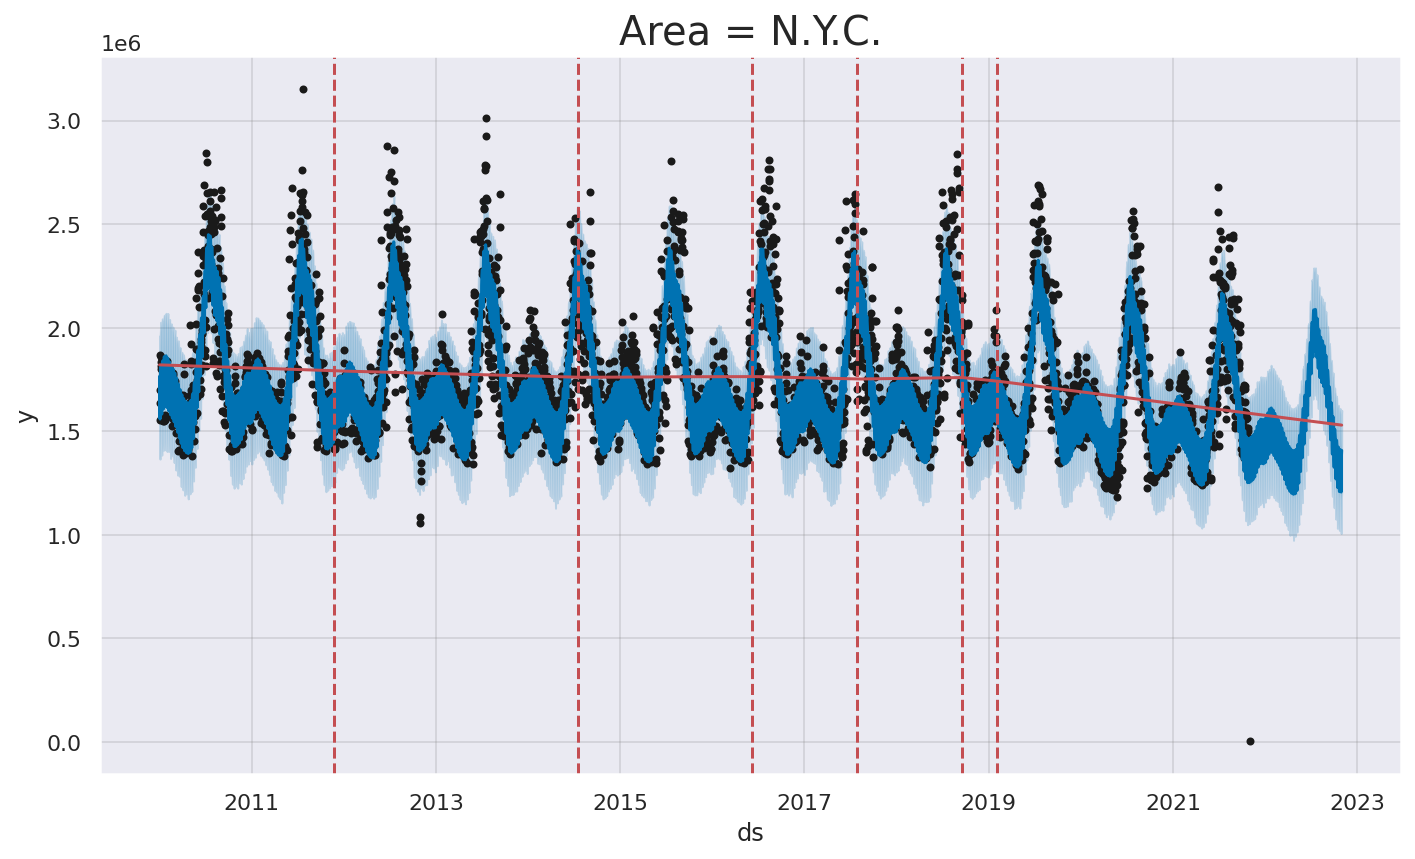

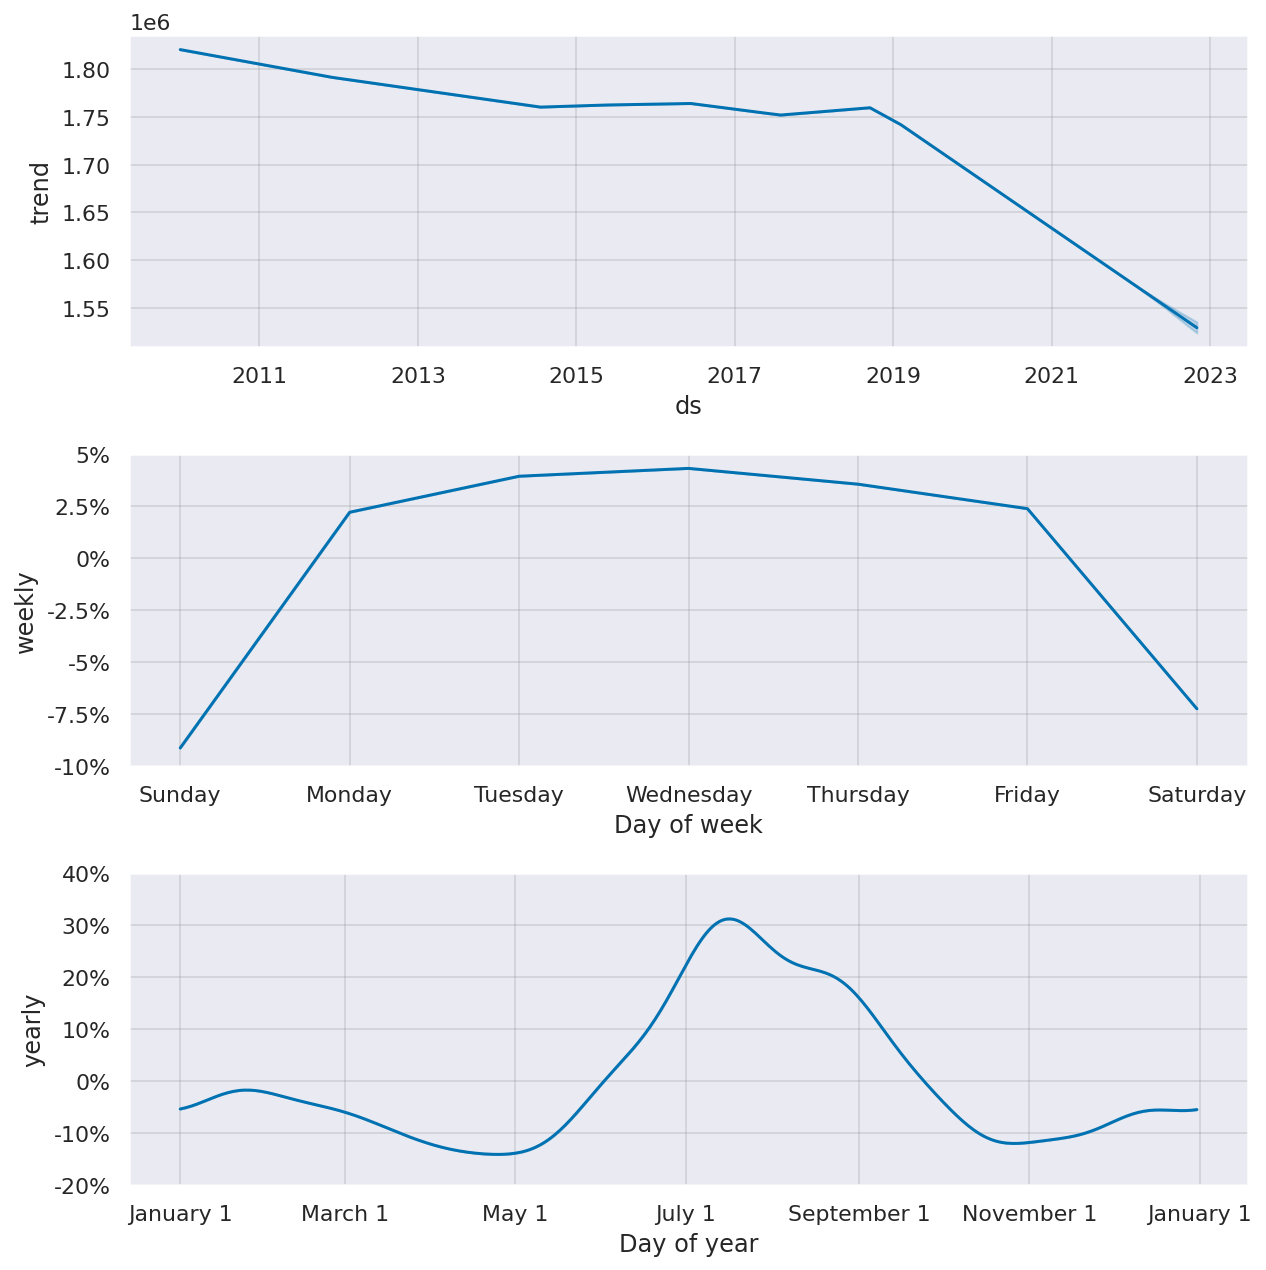

In [10]:
for i in range(len(models['zone'])):
    mymodel = models['model'][i]
    myforecast = models['forecast'][i]
    
    fig = mymodel.plot(myforecast)
    ax = fig.gca()
    a = add_changepoints_to_plot(ax, mymodel, forecast)
    ax.set_title(f"Area = {models['zone'][i]}", size=20)
    
    fig = mymodel.plot_components(myforecast)